# 0. Install libraties

In [27]:
!pip install datasets torchinfo > /dev/null 2>&1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Data Preparation

In [ ]:
from datasets import load_dataset

dataset = load_dataset('conll2003')

In [4]:
dataset = dataset.remove_columns(['id', 'chunk_tags','ner_tags'])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3453
    })
})

In [5]:
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 113

In [7]:
from torch.utils.data import Dataset

class PosTagging_Dataset(Dataset):
     def __init__(self, dataset, tokenizer):
         super().__init__()
         self.tokens = dataset['tokens']
         self.labels = dataset['pos_tags']
         self.tokenizer = tokenizer
         self.max_len = MAX_LEN

     def __len__(self):
         return len(self.tokens)

     def __getitem__(self, idx):
         input_token = self.tokens[idx]
         label_token = self.labels[idx]

         input_token = self.tokenizer.convert_tokens_to_ids(input_token)
         input_ids, labels = self.pad_and_truncate(input_token, label_token)
         return input_ids, labels

     def pad_and_truncate(self, sequence_token, sequence_label):
         pad_id = self.tokenizer.pad_token_id
         if len(sequence_token) < self.max_len:
            padded_sequence_token = sequence_token + [pad_id] * (self.max_len-len(sequence_token))
            padded_sequence_label = sequence_label + [47] * (self.max_len - len(sequence_label))
         else:
            padded_sequence_token = sequence_token[:self.max_len]
            padded_sequence_label = sequence_label[:self.max_len]

         return torch.tensor(padded_sequence_token), torch.tensor(padded_sequence_label)

In [8]:
train_set = PosTagging_Dataset(dataset_train, tokenizer)
val_set = PosTagging_Dataset(dataset_val, tokenizer)
test_set = PosTagging_Dataset(dataset_val, tokenizer)

In [9]:
from torch.utils.data import DataLoader
batch_size = 512

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(test_set, batch_size = batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# 2. Model

In [10]:
import torch.nn.functional as F

class POS_Model(nn.Module):
     def __init__(self, vocab_size, emb_dim, hidden_size, num_classes):
         super().__init__()
         self.embedding = nn.Embedding(vocab_size, emb_dim)
         self.fc1 = nn.Linear(hidden_size, 2 * hidden_size)
         self.fc2 = nn.Linear(hidden_size*2, hidden_size)
         self.fc3 = nn.Linear(hidden_size, num_classes)

     def forward(self, x):
         x = self.embedding(x)
         x = F.relu(self.fc1(x))
         x = F.relu(self.fc2(x))
         x = self.fc3(x)
         return x.permute(0, 2, 1)


In [11]:
emb_dim = 512
hidden_size = 512
vocab_size = len(tokenizer)
num_classes = 47+1

model = POS_Model(vocab_size, emb_dim, hidden_size, num_classes)

In [12]:
from torchinfo import summary

input_data = torch.randint(low=0, high=vocab_size-1, size=(512, MAX_LEN))
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
POS_Model                                [512, 48, 113]            --
├─Embedding: 1-1                         [512, 113, 512]           15,627,264
├─Linear: 1-2                            [512, 113, 1024]          525,312
├─Linear: 1-3                            [512, 113, 512]           524,800
├─Linear: 1-4                            [512, 113, 48]            24,624
Total params: 16,702,000
Trainable params: 16,702,000
Non-trainable params: 0
Total mult-adds (G): 8.55
Input size (MB): 0.46
Forward/backward pass size (MB): 970.13
Params size (MB): 66.81
Estimated Total Size (MB): 1037.40

# 3. Evaluate

In [13]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs,dim=1)
          total += (labels != 47).sum().item()
          test_loss += loss.item()
          correct += torch.multiply(predicted==labels, labels != 47).sum().item()

      test_loss = test_loss / len(test_loader)
      accuracy = 100 * correct / total

      return test_loss, accuracy


In [14]:
inputs, labels = next(iter(test_loader))

In [15]:
inputs.shape, labels.shape

(torch.Size([512, 113]), torch.Size([512, 113]))

In [16]:
tokenizer.pad_token_id

0

In [17]:
inputs[0], labels[0]

(tensor([ 100, 1011,  100,  100,  100,  100,  100,  100,  100,  100, 1012,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]),
 tensor([22,  8, 22, 22, 15, 22, 22, 22, 22, 21,  7, 47, 47, 47, 47, 47, 47, 47,
         47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
         47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,

# 4. Train Model

In [18]:
a = torch.randn((1,2))
b = torch.randn((1,2))
a,b

(tensor([[ 2.2876, -0.2800]]), tensor([[1.1287, 2.0919]]))

In [19]:
torch.multiply(a,b)

tensor([[ 2.5820, -0.5857]])

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
LR = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index=47)

In [23]:
def train_model(model):
    model.train()
    hist = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    model.to(device)
    for epoch in range(EPOCHS):
        model.train()
        total = 0
        running_loss = 0.0
        running_correct = 0

        for inputs, labels in train_loader:
           inputs, labels = inputs.to(device), labels.to(device)

           optimizer.zero_grad()
           outputs = model(inputs)
           loss = criterion(outputs, labels)
           running_loss += loss.item()
           _, predicted = torch.max(outputs, 1)
           total += (labels != 47).sum().item()
           running_correct += torch.multiply(predicted == labels, labels != 47).sum().item()

           loss.backward()
           optimizer.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * running_correct / total
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        hist['train_loss'].append(epoch_loss)
        hist['train_accuracy'].append(epoch_accuracy)
        hist['val_loss'].append(val_loss)
        hist['val_accuracy'].append(val_accuracy)


    return hist


In [24]:
print('Training FC model')
hist = train_model(model)

Training FC model
Epoch [1/50], Loss: 0.6226, Accuracy: 83.79%, Val loss: 0.6737, Val Accuracy: 82.87%
Epoch [2/50], Loss: 0.6039, Accuracy: 84.18%, Val loss: 0.6710, Val Accuracy: 82.95%
Epoch [3/50], Loss: 0.6004, Accuracy: 84.18%, Val loss: 0.6738, Val Accuracy: 82.97%
Epoch [4/50], Loss: 0.5998, Accuracy: 84.18%, Val loss: 0.6748, Val Accuracy: 83.02%
Epoch [5/50], Loss: 0.5989, Accuracy: 84.19%, Val loss: 0.6757, Val Accuracy: 82.96%
Epoch [6/50], Loss: 0.5979, Accuracy: 84.19%, Val loss: 0.6752, Val Accuracy: 83.00%
Epoch [7/50], Loss: 0.5967, Accuracy: 84.21%, Val loss: 0.6766, Val Accuracy: 82.97%
Epoch [8/50], Loss: 0.5962, Accuracy: 84.23%, Val loss: 0.6770, Val Accuracy: 82.93%
Epoch [9/50], Loss: 0.5954, Accuracy: 84.24%, Val loss: 0.6773, Val Accuracy: 82.96%
Epoch [10/50], Loss: 0.5950, Accuracy: 84.23%, Val loss: 0.6777, Val Accuracy: 82.96%
Epoch [11/50], Loss: 0.5947, Accuracy: 84.24%, Val loss: 0.6782, Val Accuracy: 82.97%
Epoch [12/50], Loss: 0.5943, Accuracy: 84.25%

# 5. Plot result

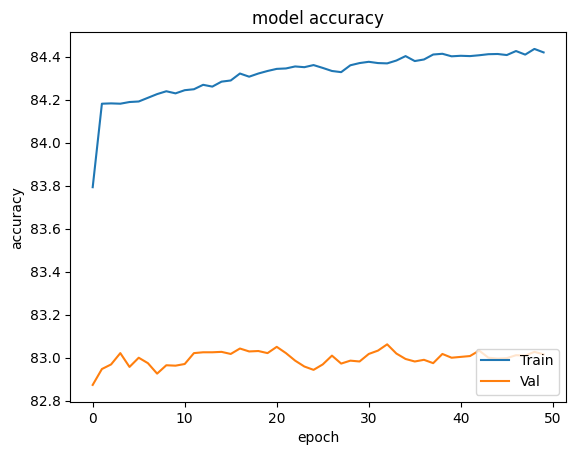

In [25]:
import matplotlib.pyplot as plt

plt.plot(hist['train_accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Val')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

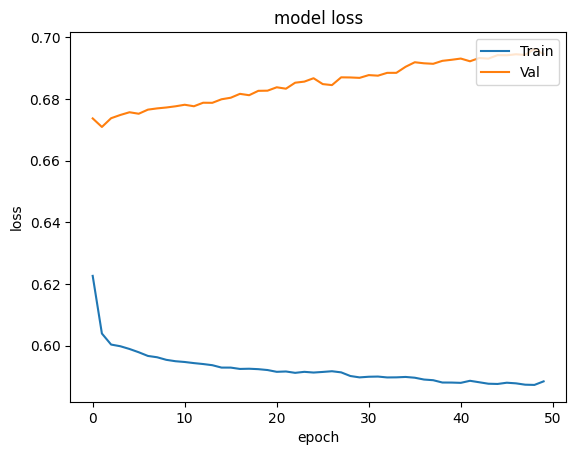

In [26]:
plt.plot(hist['train_loss'], label='Train')
plt.plot(hist['val_loss'], label='Val')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')